# Introduction to Echo State Networks based on the Example of Stock Price Prediction

In this notebook, we show how echo state networks (ESN) can be used for time series prediction and especially the prediction of stock price dynamics. In the following, the basic model is introduced with a focus on the design and hyperparameterization of echo state networks in python. Here, for the sake of simplicity, we limit ourselves to the case of a single stock prices time series.

## Import 

In [1]:
import numpy as np
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from sklearn.linear_model import Ridge

## Load and plot data 

We collected stock data for Apple on 880 trading days, from January 1, 2020, to July 1, 2023. These stock data includes volumes and opening, closing,
highest, lowest, and adjusted closing prices. We load data using the Python package Yahoo Finance (yfinance).


In [2]:
stock_data = yf.download("AAPL", start="2020-01-01", end="2023-07-15")
print(stock_data.head())

[*********************100%%**********************]  1 of 1 completed

                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2020-01-02  74.059998  75.150002  73.797501  75.087502  72.960464  135480400
2020-01-03  74.287498  75.144997  74.125000  74.357498  72.251137  146322800
2020-01-06  73.447502  74.989998  73.187500  74.949997  72.826851  118387200
2020-01-07  74.959999  75.224998  74.370003  74.597504  72.484344  108872000
2020-01-08  74.290001  76.110001  74.290001  75.797501  73.650345  132079200


Next, we plot the collected closing prices, which are the volume-weighted average prices of all trades (including the last trade) within the last
minute of trading and are important for stock price forecasting.

Text(0.5, 0, 'Day')

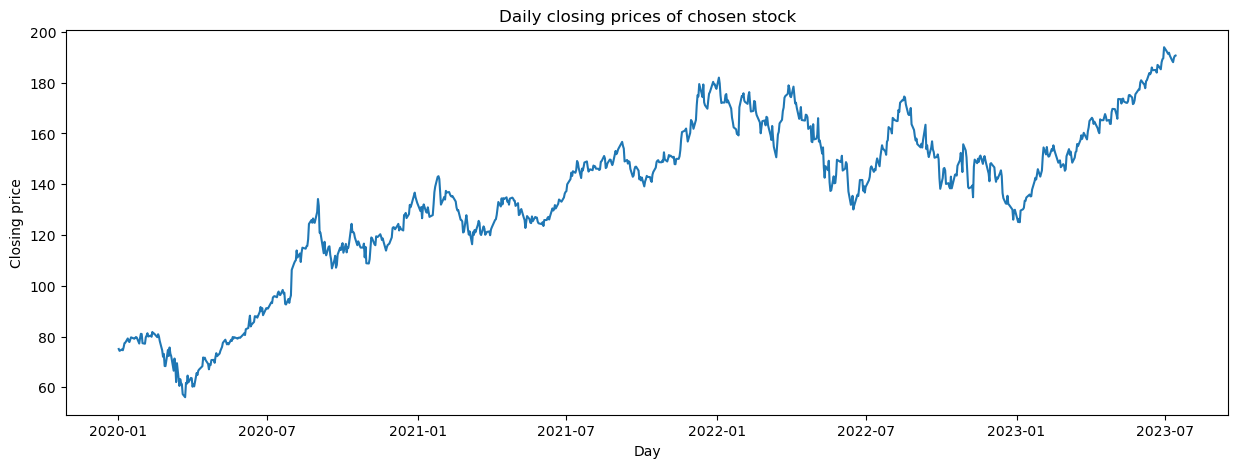

In [3]:
close_prices = stock_data['Close']

plt.figure(figsize=[15,5])
plt.plot(close_prices)
plt.title('Daily closing prices of chosen stock')
plt.ylabel('Closing price')
plt.xlabel('Day')

## Split data into training and test set


The data set should be split in a training and a test set, because the quality of the method is not based on the error produced with the data used for training, but it is based on the potential for generalisation of the algorithm, that is, the performance on data not previously seen. In an extreme case, overfitting can happen, such that the results for the given data are very good, but new data does not achieve an acceptable outcome. To measure this, a part of the data set should not be used for training the data, but for testing the algorithm after the training procedure.

The task here is to predict 2 days ahead by using the previous 800 days (training data) and do that for 80 future points (test data). So, in the end you will have a 80 time step prediction with dif = 2.

In [4]:
trainLen = 300
testLen = 100
dif = 2  # prediction horizon >=1

In [5]:
data = np.array(close_prices)
X = data[0:trainLen] 
y = data[dif:trainLen+dif]
Xtest = data[trainLen:trainLen+testLen]
ytest = data[trainLen+dif:trainLen+testLen+dif]

## Building and training the Echo State Network

In this section, we build and train the echo state network (based on https://www.ai.rug.nl/minds/uploads/PracticalESN.pdf and https://github.com/alexander-rakhlin/ESN). 

Echo State Networks are a simple type of recurrent neural networks (RNN) which utilize reservoir computation. The figure below illustrates the standard ESN structure, which includes input data (i.e., stock prices, $\mathbf{u}(n)$), reservoir activation states, and network output ($\mathbf{y}(n)$). The main difference between an ESN and a 'traditional' neural network is that the input and recurrent weight matrices $\mathbf{W}_{in}$ and $\mathbf{W}_{res}$ are initilized and set randomly when the network is established, such that little training is required. Solely, the output weight matrix $\mathbf{W}_{out}$ is trained. Moreover, the typical update equations are

$\tilde{x}(n) = \mathrm{tanh} (\mathbf{W}_{in} + \mathbf{W}_{res} \mathbf{x}(n-1))$, 

$\mathbf{x}(n) = (1-\alpha) \mathbf{x}(n-1) + \alpha \mathbf{\tilde{x}}(n)$ ,

where $x(n)$ is a vector of reservoir neuron activations, $\mathbf{\tilde{x}}(n)$ is its update at timestep $n$ and $\alpha$ describes the leaking rate, which can be regarded as the speed of the reservoir update dynamics.




![Structure of Echo State Networks, Source: https://www.researchgate.net/figure/Echo-State-Networks_fig1_341400201](https://www.researchgate.net/publication/341400201/figure/fig1/AS:891444382412802@1589548311658/Echo-State-Networks.png)

In [6]:
np.random.seed(42)
      
class ESN(object):

    def __init__(self, resSize=500, rho=0.9, cr=0.05, leaking_rate=0.2, W=None):

        self.resSize = resSize
        self.leaking_rate = leaking_rate

        if W is None:
            N = resSize * resSize
            W = np.random.rand(N) - 0.5
            zero_index = np.random.permutation(N)[int(N * cr * 1.0):]
            W[zero_index] = 0
            W = W.reshape((self.resSize, self.resSize))
            print('ESN init: Setting spectral radius...')
            rhoW = max(abs(linalg.eig(W)[0]))
            print('done.')
            W *= rho / rhoW
        else:
            assert W.shape[0] == W.shape[1] == resSize, "reservoir size mismatch"
        self.W = W

    def __init_states__(self, X, initLen, reset_state=True):

        self.S = np.zeros((len(X) - initLen, 1 + self.inSize + self.resSize))
        if reset_state:
            self.s = np.zeros(self.resSize)
        s = self.s.copy()

        for t, u in enumerate(X):
            s = (1 - self.leaking_rate) * s + self.leaking_rate *\
                                np.tanh(np.dot(self.Win, np.hstack((1, u))) +\
                                np.dot(self.W, s))
            if t >= initLen:
                self.S[t-initLen] = np.hstack((1, u, s))
        if reset_state:
            self.s = s

    def fit(self, X, y, lmbd=1e-6, initLen=100, init_states=True):
        assert len(X) == len(y), "input lengths mismatch."
        self.inSize =  1 if np.ndim(X) == 1 else X.shape[1]
        if init_states:
            print("ESN fit_ridge: Initializing states..."),
            self.Win = (np.random.rand(self.resSize, 1 + self.inSize) - 0.5) * 1
            self.__init_states__(X, initLen)
            print("done.")
        self.ridge = Ridge(alpha=lmbd, fit_intercept=False,
                               solver='svd', tol=1e-6)
        self.ridge.fit(self.S, y[initLen:])
        return self

    def predict(self, X, init_states=True):
        if init_states:        
            self.__init_states__(X, 0, reset_state=False)
        y = self.ridge.predict(self.S)
        return y
        
  

We now establish the model with a reservoir size of 100 and set the hyperparameters to: 

- a spectral radius (rho) of 1
- a connectivity ratio (cr) of 1
- a leaking rate of 1
- a regularization coefficient (lmbd) of 1e-2

Then, the ESN is trained. Note, that the performance is significantly dependent on the set hyperparameters. General rules of thumb, which should be considered when setting hyperparameters in ESNs are published in "A Practical Guide to Applying Echo State Networks" by Lukosevicius (2012). Here, we concentrate on the following three key parameters: reservoir size, spectral radius, and the connectivity ratio of reservoirs. The reservoir size represents the number of neurons in the pool, is generally related to the number of samples and it has a certain effect on the network performance. A larger size means a more accurate stock forecast (however, keep in mind overfitting), while a too small size leads to underfitting. If the spectral radius of $W_{res}$ is less than 1, ESN will stay in an echo state (cf. Lukosevicius, 2012).  The connectivity ratio of a reservoir represents the connections between its neurons, meaning the more connections the stronger the nonlinear approximation ability (also cf. https://pdfs.semanticscholar.org/e3a7/2a2b7d6071461007112f12c8716529755d39.pdf).
 

In [7]:
resSize = 500
rho = 0.999
cr = 0.02
leaking_rate = 1.
lmbd = 1e-6

esn = ESN(resSize=resSize, rho=rho, cr=cr, leaking_rate=leaking_rate)
    
esn.fit(X, y, initLen=100, lmbd=lmbd)
y_predicted = esn.predict(Xtest)

ESN init: Setting spectral radius...
done.
ESN fit_ridge: Initializing states...
done.


## Analysis of the model

We plot the training and test data to the predicted data of the ESN and evaluated the performance of ESN based on the root mean square error (RMSE) of forecast values ($y_t^p$) and actual values ($y_t$) at time $t$ with a total number of forecast values $N$:

$RMSE = \sqrt{\frac{1}{N} \sum_{t=1}^N ( y_t - y_t^p)^2}$

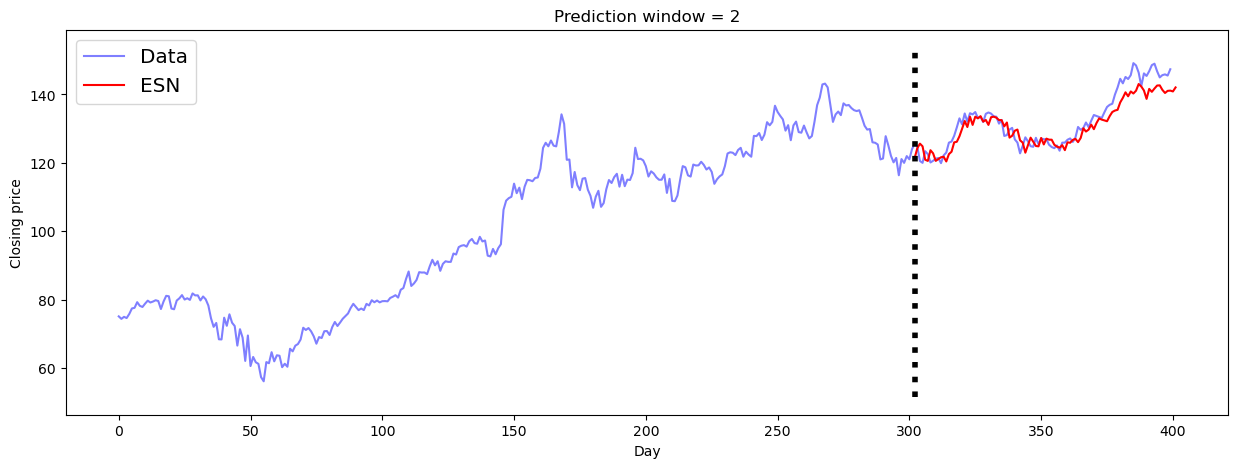

In [8]:
plt.figure(figsize=(15,5))
plt.plot(range(0,trainLen+testLen),data[0:trainLen+testLen],'b',alpha =0.5,label="Data")
plt.plot(range(trainLen+dif,trainLen+testLen+dif),y_predicted,'red', label="ESN")
plt.legend(loc='upper left',fontsize='x-large')
plt.title('Prediction window = 2')
plt.ylabel('Closing price')
plt.xlabel('Day')
lo,hi = plt.ylim()
plt.plot([trainLen+dif,trainLen+dif],[lo+np.spacing(1),hi-np.spacing(1)],'k:', linewidth=4)

In [9]:
RMSE = np.sqrt(np.sum(np.square(ytest-y_predicted))/testLen)
print('RMSE:', RMSE)

RMSE: 3.435271780942059


The result shows, that the method works quite well, but keep in mind, that the above model was made with a prediction window of two days, meaning that we are only ever predicting 2 days into the future at any given time. 

Next, we analyse the dependency of the RMSE with regard to the prediction window length.

## RSME as function of prediction window length

ESN init: Setting spectral radius...
done.
ESN fit_ridge: Initializing states...
done.
ESN init: Setting spectral radius...
done.
ESN fit_ridge: Initializing states...
done.
ESN init: Setting spectral radius...
done.
ESN fit_ridge: Initializing states...
done.
ESN init: Setting spectral radius...
done.
ESN fit_ridge: Initializing states...
done.


Text(0, 0.5, 'RMSE')

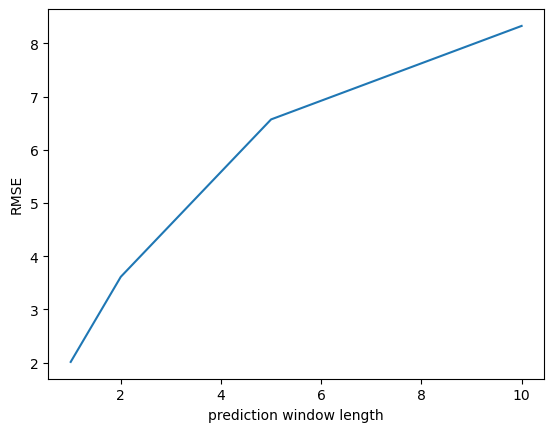

In [10]:
RMSE = []
wl = [1,2,5,10]

for i in wl:
    dif = i  
    data = np.array(close_prices)
    y = data[dif:trainLen+dif]
    ytest = data[trainLen+dif:trainLen+testLen+dif]
    esn = ESN(resSize=resSize, rho=rho, cr=cr, leaking_rate=leaking_rate)
    esn.fit(X, y, initLen=100, lmbd=lmbd)
    y_predicted = esn.predict(Xtest)


    RMSE.append(np.sqrt(np.sum(np.square(ytest-y_predicted))/testLen))

plt.plot(wl,RMSE)
plt.xlabel('prediction window length')
plt.ylabel('RMSE')

In the future predictions, the error increases in time such that as the window length is increased the accuracy decreases. We can see this behavior in the plot above, where longer predictions show a larger RMSE.

## Changing the reservoir size

To get a feeling for the training behavior, the training may be conducted for various reservoir sizes.

ESN init: Setting spectral radius...
done.
ESN fit_ridge: Initializing states...
done.
ESN init: Setting spectral radius...
done.
ESN fit_ridge: Initializing states...
done.
ESN init: Setting spectral radius...
done.
ESN fit_ridge: Initializing states...
done.
ESN init: Setting spectral radius...
done.
ESN fit_ridge: Initializing states...
done.


Text(0.5, 0, 'Day')

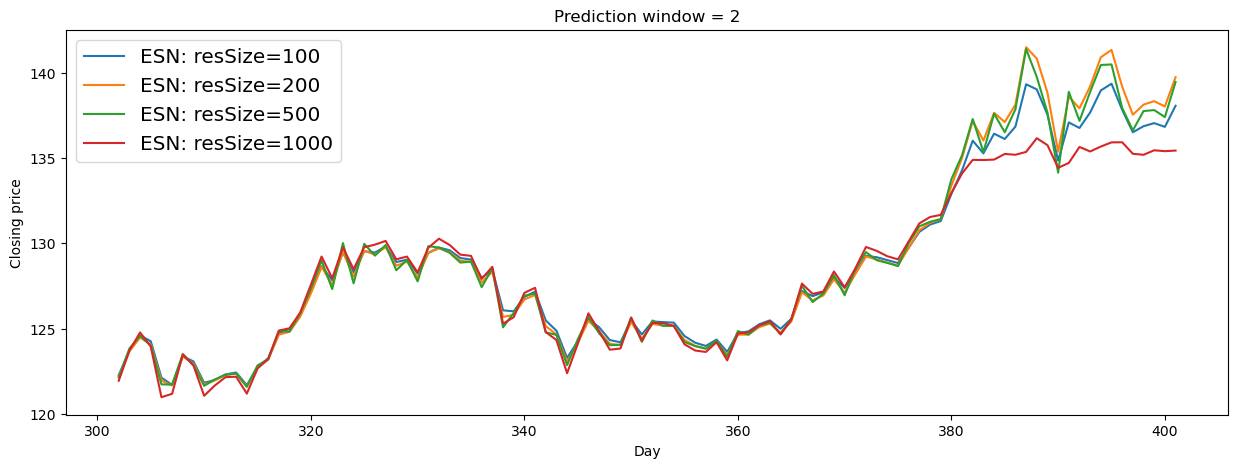

In [12]:
RMSE = []
resSize = [100,200,500,1000]

plt.figure(figsize=(15,5))
for i in resSize:
    dif = 2
    data = np.array(close_prices)
    esn = ESN(resSize=i, rho=rho, cr=cr, leaking_rate=leaking_rate)
    esn.fit(X, y, initLen=100, lmbd=lmbd)
    y_predicted = esn.predict(Xtest)

    plt.plot(range(trainLen+dif,trainLen+testLen+dif),y_predicted, label="ESN: resSize="+str(i))

    RMSE.append(np.sqrt(np.sum(np.square(ytest-y_predicted))/testLen))

plt.legend(loc='upper left',fontsize='x-large')
plt.title('Prediction window = 2')
plt.ylabel('Closing price')
plt.xlabel('Day')